In [1]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py
from astropy import units as u_sci
import cmbdb as cmb


In [2]:
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.component_model import CMB, Dust, Synchrotron
from fgbuster.separation_recipes import standardize_instrument, _intersect_mask,_get_prewhiten_factors,_A_evaluator,_get_alms,_format_alms,_r_to_c_alms

import fgbuster.algebra as alg
from fgbuster.observation_helpers import get_instrument,get_noise_realization,get_sky,get_observation
from fgbuster.cosmology import _get_Cl_noise
from fgbuster.separation_recipes import harmonic_comp_sep, basic_comp_sep

In [3]:
import os
import platform

print("Name:        ", os.name)
print("System:      ", platform.system())
print("Release:     ", platform.release())
print("Architecture:", platform.architecture())
print("Machine:     ", platform.machine())
print("Processor:   ", platform.processor())
print("Release:     ", platform.release())
print("Version:     ", platform.version())

# On Windows:
# nt
# Windows
# 10


if platform.system() != 'Windows':
    print("Uname:       ", os.uname())

# On Windows uname is not available

Name:         posix
System:       Linux
Release:      3.10.0-1127.el7.x86_64
Architecture: ('64bit', 'ELF')
Machine:      x86_64
Processor:    x86_64
Release:      3.10.0-1127.el7.x86_64
Version:      #1 SMP Tue Mar 31 23:36:51 UTC 2020
Uname:        posix.uname_result(sysname='Linux', nodename='ansys06', release='3.10.0-1127.el7.x86_64', version='#1 SMP Tue Mar 31 23:36:51 UTC 2020', machine='x86_64')


In [4]:
%config Completer.use_jedi = False

In [5]:
def D_ell(C_ell):
    # Determine the length of the input power spectrum
    n_ell = len(C_ell)

    # Create an array of zeros to store the scale invariant power spectrum
    D_ell = np.zeros(n_ell)

    # Compute the scale invariant power spectrum using vectorized operations
    # Vectorized operations eliminate the need for a for loop, improving performance

    # Compute the product of each element with the next element using np.arange(n_ell) * (np.arange(n_ell) + 1)
    # Multiply the above result by C_ell to perform element-wise multiplication with the corresponding elements in C_ell
    # Divide the above result by np.pi to perform element-wise division by pi
    D_ell = np.arange(n_ell) * (np.arange(n_ell) + 1) * C_ell / np.pi

    # Return the computed scale invariant power spectrum
    return D_ell

In [6]:
def frac_diff(a,b):
    return(np.linalg.norm(a-b)/np.linalg.norm(b))

In [7]:
amin2rad = np.pi/(60.*180.)

In [8]:
def degrade_alm2map(alms_in,nside_out,lmax_out,filter,pol = True):
    map1 = hp.alm2map(alms_in,nside=nside_out)
    alms1 = hp.map2alm(map1,lmax=lmax_out)
    for j in range(alms1.shape[0]): 
        if pol : 
            hp.almxfl(alms1[j],filter[:,j],inplace=True)
        else :
            hp.almxfl(alms1[j],filter,inplace=True)
    return(hp.alm2map(alms1,nside=nside_out))

# Simulating Sky

In [116]:
NSIDE = 512
NSIDE_decon = 128
lmax = 2*NSIDE
lmax_decon = 2*NSIDE_decon
# lmax = 3*NSIDE-1  # Maximum ell value based on the given NSIDE value

# lmax_decon = 3*NSIDE_decon-1

sky_d0s0 = get_sky(NSIDE, 'd0s0')  # Get the sky map using the specified NSIDE and sky type 'd0s0'

instrument = get_instrument('LiteBIRD')  # Get the instrument information for 'LiteBIRD'
freq_maps_d0s0 = get_observation(instrument, sky_d0s0)
# freq_maps_d0s0 = np.zeros(freq_maps_d0s0.shape)
# Obtain the frequency maps for the given instrument and sky map.
# freq_maps_d0s0 is a 3D array containing the observed maps for each frequency channel.

num_freq, ncomp, npix = freq_maps_d0s0.shape
# Retrieve the dimensions of the freq_maps_d0s0 array.
# - num_freq represents the number of frequency channels.
# - ncomp represents the number of components in the observed map.
# - npix represents the number of pixels in the observed map.

/home/julientang2001/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


In [117]:
# instrument.fwhm = np.zeros(15)
print(instrument.fwhm)

0     70.5
1     58.5
2     51.1
3     47.1
4     43.8
5     41.5
6     37.8
7     33.6
8     30.8
9     28.9
10    28.6
11    24.7
12    22.5
13    20.9
14    17.9
Name: fwhm, dtype: float64


In [118]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")

cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]

# np.random.seed(0)
map_CMB = hp.synfast(cl_CMB_th,nside=NSIDE,new = True)

print(map_CMB.shape)
cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)

(3, 3145728)
(4, 1025)


In [119]:
alm_CMB = hp.map2alm(map_CMB,lmax)
for i in range(alm_CMB.shape[0]):
    hp.almxfl(alm_CMB[i], hp.gauss_beam(hp.nside2resol(64)), inplace=True)

## Compare alm2map with nside_out and ud_grade

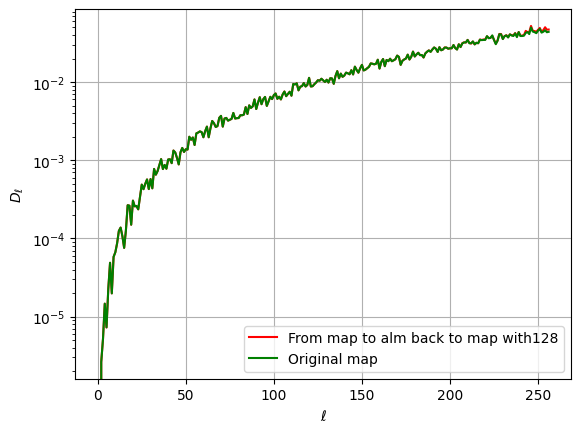

In [120]:
# map_CMB_dg1 = hp.alm2map(alm_CMB,nside=NSIDE_decon)
# map_CMB_alm_dg = hp.map2alm(map_CMB_dg1,lmax=lmax_decon)
# map_CMB_alm_dg = np.array([hp.almxfl(alm_dg,1/hp.gauss_beam(hp.nside2resol(64)), inplace=True) for alm_dg in map_CMB_alm_dg])
# map_CMB_dg1 = hp.alm2map(map_CMB_alm_dg,nside=NSIDE_decon)
map_CMB_dg1 = degrade_alm2map(alm_CMB,nside_out=NSIDE_decon,lmax_out=lmax_decon,filter=1/hp.gauss_beam(hp.nside2resol(64)),pol=False)

map_CMB_dg2 = hp.ud_grade(map_CMB,nside_out=NSIDE_decon)
l_arr = np.arange(lmax_decon+1)
Cl_CMB1 = hp.anafast(map_CMB_dg1,lmax=lmax_decon)
Cl_CMB2 = hp.anafast(map_CMB_dg2,lmax=lmax_decon)
Cl_CMB3 = hp.anafast(map_CMB,lmax=lmax)

py.plot(l_arr,D_ell(Cl_CMB1[2]),'r',label = 'From map to alm back to map with'+str(NSIDE_decon))
# py.plot(l_arr,D_ell(Cl_CMB2[2]),'b',label = 'Original map degraded to Nside_out')
py.plot(l_arr,D_ell(Cl_CMB3[2,:lmax_decon+1]),'g',label = 'Original map')
# py.plot(l_arr,D_ell(cl_CMB_crop_th[2,:lmax_decon+1]),'k',label = 'Theoretical power spectra')
# py.axvline(NSIDE_decon,linestyle = '--')
py.grid()
py.xlabel(r'$\ell$')
py.ylabel(r'$D_{\ell}$')
py.legend(loc='best')
py.yscale('log')

In [121]:
freq_maps_simple_noiseless2 = map_CMB+freq_maps_d0s0

In [122]:
beam_array = np.array([hp.gauss_beam(f*amin2rad,lmax = lmax, pol=True) for f in instrument.fwhm])
print(beam_array.shape)

(15, 1025, 4)


In [123]:
B_pix = hp.gauss_beam(hp.nside2resol(64),pol=True)
print(B_pix.shape)

(513, 4)


In [124]:
inv_beam_arr = 1./beam_array
fwhm_common = 80*amin2rad
beam_common = hp.gauss_beam(fwhm_common,lmax = lmax, pol = True)
b_c = np.array([beam_common*beam_inv for beam_inv in inv_beam_arr])
print(b_c.shape)

(15, 1025, 4)


## Beam (check with hp.smoothing)

In [125]:
alm_CMB_smooth = np.array([hp.almxfl(alm_CMB[j],beam_common[:,j]) for j in range(ncomp)])
map_CMB_smooth = hp.alm2map(alm_CMB_smooth,nside=NSIDE_decon)
alm_CMB_smooth = hp.map2alm(map_CMB_smooth,lmax=lmax_decon)
alm_CMB_smooth = np.array([hp.almxfl(alm_CMB_smooth[j],1/B_pix[:,j], inplace=True) for j in range(ncomp)])
map_CMB_smooth = hp.alm2map(alm_CMB_smooth,nside=NSIDE_decon)
cl_CMB_smooth = hp.anafast(map_CMB_smooth,lmax=lmax_decon,alm=False)

Transform you sky map (CMB + fg) in alm


In [126]:
sky_alm = np.array([hp.map2alm(sky_map,lmax) for sky_map in freq_maps_simple_noiseless2])
sky_alm = np.array([np.array([hp.almxfl(sky_alm[i,j], B_pix[:,j]) for j in range(ncomp)]) for i in range(num_freq)])


#### Beaming maps
We want to compute $(B \ast As)_p$.
We start with convolution of the noiseless signal.

In [127]:
BAS_alm_nl_smooth = np.array([np.array([hp.almxfl(sky_alm[i,j],beam_array[i,:,j] )for j in range(0,ncomp) ]) for i in range(0,num_freq)])
print(BAS_alm_nl_smooth.shape)


(15, 3, 525825)


In [128]:
print(BAS_alm_nl_smooth-sky_alm)

[[[ 0.00000000e+00+0.j -1.70136593e-04+0.j  3.28640245e-02+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  9.50756895e-04+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j -1.52433608e-05+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]]

 [[ 0.00000000e+00+0.j -3.85511216e-05+0.j  2.13723214e-02+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  4.11119526e-04+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j -1.17575194e-05+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]]

 [[ 0.00000000e+00+0.j  3.14803886e-06+0.j  1.73796922e-02+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  2.49732640e-04+0.j ...
    0.000000

In [129]:
BAS_p_nl =  np.array([hp.alm2map(alm_BAS,nside=NSIDE_decon) for alm_BAS in BAS_alm_nl_smooth])
BAS_alm_dg = np.array([hp.map2alm(map,lmax=lmax_decon) for map in BAS_p_nl])
BAS_alm_dg = np.array([np.array([hp.almxfl(BAS_alm_dg[i,j],1/B_pix[:,j], inplace=True) for j in range(ncomp)  ]) for i in range(num_freq)])
BAS_p_nl_dg = np.array([hp.alm2map(map,nside=NSIDE_decon) for map in BAS_alm_dg])

In [130]:
AS_alm_inv = np.array([np.array([hp.almxfl(BAS_alm_nl_smooth[i,j],inv_beam_arr[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])


In [131]:
print(frac_diff(AS_alm_inv,sky_alm))

9.227225802452941e-17


Finally go back to map using alm2map and that's where you go to your desired lower nside i.e. alm2map(PreProcessedMap, NSIDE_OUT)

In [132]:
AS_p_inv = np.array([hp.alm2map(alm_inv,nside=NSIDE_decon) for alm_inv in AS_alm_inv])


AS_alm_dg = np.array([hp.map2alm(map,lmax=lmax_decon) for map in AS_p_inv])
AS_alm_dg = np.array([np.array([hp.almxfl(AS_alm_dg[i,j],1/B_pix[:,j]) for j in range(ncomp)  ]) for i in range(num_freq)])
AS_p_inv_dg = np.array([hp.alm2map(map,nside=NSIDE_decon) for map in AS_alm_dg])

In [133]:
i = 10
Cl_simple = hp.anafast(freq_maps_simple_noiseless2[i],lmax=lmax_decon,alm=False)
Cl_smooth = hp.anafast(BAS_p_nl_dg[i],lmax = lmax_decon,alm=False)
Cl_unsmooth = hp.anafast(AS_p_inv_dg[i],lmax = lmax_decon,alm=False)   
# Cl_sky_alm = hp.alm2cl(sky_alm[i],lmax=lmax_decon)

In [134]:
AS_alm_ren = np.array([np.array([hp.almxfl(BAS_alm_nl_smooth[i,j],b_c[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

AS_p_ren = np.array([hp.alm2map(alm_ren,nside=NSIDE_decon) for alm_ren in AS_alm_ren])
AS_alm_ren_dg = np.array([hp.map2alm(map_dg,lmax=lmax_decon) for map_dg in AS_p_ren])
AS_alm_ren_dg = np.array([np.array([hp.almxfl(AS_alm_ren_dg[i,j],1/B_pix[:,j]) for j in range(ncomp)  ]) for i in range(num_freq)])
AS_p_ren_dg = np.array([hp.alm2map(map,nside=NSIDE_decon) for map in AS_alm_ren_dg])


## Component separation

In [135]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [136]:
# The starting point of the fit is the pysm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]

In [137]:
result_basic_inv= basic_comp_sep(components, instrument, AS_p_inv_dg[:,1:3,:], # verbose output                        
                       )  ## noiseless



In [138]:

result_basic_ren = basic_comp_sep(components, instrument,AS_p_ren_dg[:,1:3,:] # verbose output             
                               )
result_harmo_ren = harmonic_comp_sep(components, instrument, AS_p_ren_dg,nside=NSIDE_decon,lmax=lmax_decon  # verbose output             
                               )

Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


In [139]:
print(result_basic_inv.s.shape)
result_harmo_inv= harmonic_comp_sep(components, instrument, AS_p_inv_dg,nside=NSIDE_decon,lmax=lmax_decon # verbose output                        
                       )  ## noiseless

print(result_harmo_inv.s.shape)

(3, 2, 196608)
Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]


(3, 2, 33153)


/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


In [140]:
NSIDE=NSIDE_decon
lmax = lmax_decon


In [141]:
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]
print('Basic + deconvolved'+'\n')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_basic_inv.params, result_basic_inv.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))


print('\n'+'Harmonic + deconvolved'+'\n')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_harmo_inv.params, result_harmo_inv.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

print('\n'+'Basic + reconvolved'+'\n')

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_basic_ren.params, result_basic_ren.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))
print('\n'+'Harmonic + reconvolved'+'\n')

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_harmo_ren.params, result_harmo_ren.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

Basic + deconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000

Harmonic + deconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000

Basic + reconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000

Harmonic + reconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000


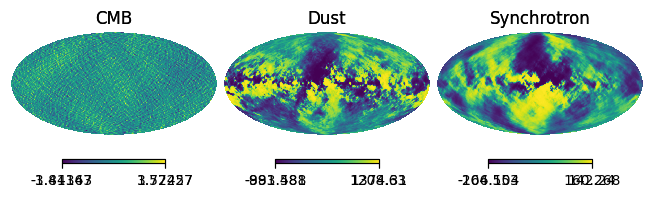

In [142]:
hp.mollview(result_basic_inv.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_basic_inv.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_basic_inv.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))
hp.mollview(result_basic_ren.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_basic_ren.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_basic_ren.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

Harmonic comp sep : from $a_{\ell m}$ to map

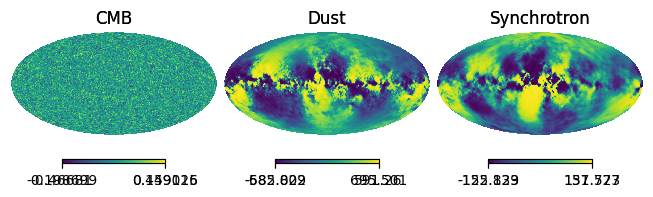

In [143]:
hp.mollview(hp.alm2map(result_harmo_inv.s[0,1],NSIDE,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_harmo_inv.s[1,1],NSIDE,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_harmo_inv.s[2,1],NSIDE,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))
hp.mollview(hp.alm2map(result_harmo_ren.s[0,1],NSIDE,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_harmo_ren.s[1,1],NSIDE,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_harmo_ren.s[2,1],NSIDE,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))


# Retrieved Power spectrum

# Residuals

For harmonic comp sep

In [144]:
alm_CMB = hp.map2alm(map_CMB_dg1,lmax_decon)


In [145]:
res_CMB_alm_inv = result_harmo_inv.s[0,0:2]-alm_CMB[1:3]


In [146]:
map_CMB = map_CMB_dg1
map_CMB_smooth =  hp.alm2map(alm_CMB_smooth,nside=NSIDE_decon,lmax=lmax_decon)

Basic component separation

In [147]:
res_CMB_map_inv = result_basic_inv.s[0]-map_CMB[1:3]


In [148]:
npix = hp.nside2npix(nside=NSIDE_decon)

In [149]:
res_CMB_alm_ren = result_harmo_ren.s[0,0:2]-alm_CMB_smooth[1:3]
res_CMB_map_ren = result_basic_ren.s[0]-map_CMB_smooth[1:3]

In [150]:
res_CMB_TEB_inv = np.zeros((3,npix),dtype=complex)
res_CMB_TEB_inv[1:3] = res_CMB_map_inv
print(res_CMB_TEB_inv.shape)

(3, 196608)


In [151]:
res_CMB_TEB_ren = np.zeros((3,npix),dtype=complex)
res_CMB_TEB_ren[1:3] = res_CMB_map_ren
print(res_CMB_TEB_ren.shape)
C_l_res_basic_ren =hp.anafast(res_CMB_TEB_ren,lmax = lmax,alm=False,pol=True)


(3, 196608)


/home/julientang2001/.conda/envs/FGBuster_JT/lib/python3.11/site-packages/healpy/sphtfunc.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(


In [152]:
C_l_res_basic_inv =hp.anafast(res_CMB_TEB_inv,lmax = lmax,alm=False,pol=True)
print(C_l_res_basic_inv.shape)

(6, 257)


In [153]:
C_l_res_harmo_inv=hp.alm2cl(res_CMB_alm_inv,lmax=lmax)


In [154]:
print(C_l_res_harmo_inv.shape)

(3, 257)


In [155]:
C_l_res_harmo_ren=hp.alm2cl(res_CMB_alm_ren,lmax=lmax)

# Retrieved CMB power spectra

In [156]:
ret_CMB_TEB_inv = np.zeros((3,npix),dtype=complex)
ret_CMB_TEB_inv[1:3] = result_basic_inv.s[0]
print(ret_CMB_TEB_inv.shape)

(3, 196608)


In [157]:
ret_CMB_TEB_ren = np.zeros((3,npix),dtype=complex)
ret_CMB_TEB_ren[1:3] = result_basic_ren.s[0]
print(ret_CMB_TEB_ren.shape)
C_l_ret_basic_ren =hp.anafast(ret_CMB_TEB_ren,lmax = lmax,alm=False,pol=True)
C_l_ret_harmo_ren=hp.alm2cl(result_harmo_ren.s[0],lmax=lmax)

(3, 196608)


In [158]:
C_l_ret_basic_inv =hp.anafast(ret_CMB_TEB_inv,lmax = lmax,alm=False,pol=True)

print(C_l_ret_basic_inv.shape)

(6, 257)


In [159]:
C_l_ret_harmo_inv=hp.alm2cl(result_harmo_inv.s[0],lmax=lmax)


# + Gravitational waves

In [160]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB_GW = hp.synfast(cl_GW,nside=NSIDE_decon)

(4, 4101)
(4, 257)


In [161]:
print(cl_CMB.shape)
print(cl_CMB_crop_th.shape)
print(C_l_res_basic_inv.shape)

(4, 1025)
(4, 1025)
(6, 257)


In [162]:
cl_tot_th = 0.001*cl_GW_crop+cl_CMB[:,:lmax+1]

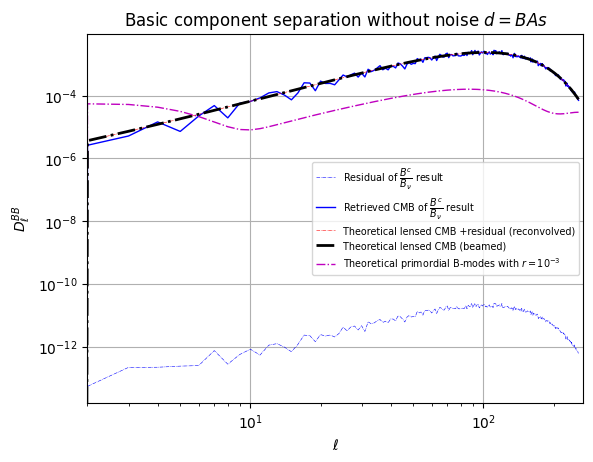

In [163]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
# # ax1.tick_params('x', labelsize=6)
# ax1.plot(l_arr,D_ell(C_l_res_basic_inv[2]),'g-.',linewidth =.4,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(C_l_ret_basic_inv[2]),'g',linewidth = 1,label = 'Retrieved CMB of $\dfrac{1}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(C_l_res_basic_inv[2]+cl_CMB_crop_th[2,:lmax+1]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (deconvolved)")
# ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2,:lmax+1]),'k-.',linewidth =2,label = "Theoretical lensed CMB ")


py.title('Basic component separation without noise $d=BAs$')


ax1.plot(l_arr,D_ell(C_l_res_basic_ren[2]),'b-.',linewidth =.4,label = 'Residual of $\dfrac{B^c}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_ret_basic_ren[2]),'b-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{B^c}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_res_basic_ren[2]+cl_CMB_crop_th[2,:lmax+1]*beam_common[:lmax+1,2]**2),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (reconvolved)")
ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2,:lmax+1]*beam_common[:lmax+1,2]**2),'k-.',linewidth =2,label = "Theoretical lensed CMB (beamed) ")


ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")


py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.show()

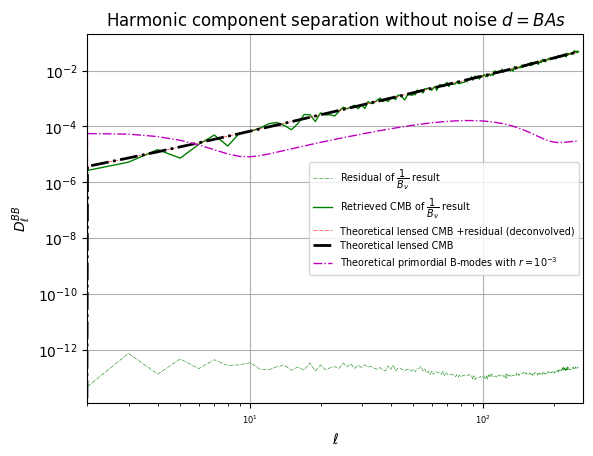

In [164]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,D_ell(C_l_res_harmo_inv[1]),'g-.',linewidth =.4,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_ret_harmo_inv[1]),'g',linewidth = 1,label = 'Retrieved CMB of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_res_harmo_inv[1]+cl_CMB_crop_th[2,:lmax+1]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (deconvolved)")
ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2,:lmax+1]),'k-.',linewidth =2,label = "Theoretical lensed CMB ")

py.title('Harmonic component separation without noise $d=BAs$')

# ax1.plot(l_arr,D_ell(C_l_res_harmo_ren[1]),'b-.',linewidth =.4,label = 'Residual of $\dfrac{B^c}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(C_l_ret_harmo_ren[1]),'b-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{B^c}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2,:lmax+1]*beam_common[:lmax+1,2]**2),'k-.',linewidth =2,label = "Theoretical lensed CMB (beamed)")
# ax1.plot(l_arr,D_ell(C_l_res_harmo_ren[1]+cl_CMB_crop_th[2,:lmax+1]*beam_common[:lmax+1,2]**2),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (reconvolved)")


ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")

# ax1.plot(l_arr,C_l_res_harmo_inv[1]/cl_CMB_crop_th[2,:lmax+1], label = 'Retrieved over theoretical')

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")


py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.show()

### Cosmological parameters

In [165]:
def cosmo_likelihood(r,C_l_obs,noise):
    if len(C_l_obs)!=lmax+1 or len(noise)!=lmax+1:
        raise Warning("Arrays should be of size "+str(lmax))
    
    C_lth =r*cl_GW_crop[2]+cl_CMB_crop_th[2]+noise
    sig = 0
    for l in range(2,lmax):
        sig+=(2*l+1)*(np.log(C_lth[l])+C_l_obs[l]/C_lth[l])
    return (sig)
